---
format:
  html:
    code-fold: false
---


## Thermo-mechanical coupling


In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
from jax import Array
import jax.numpy as jnp


import femsolver
from femsolver.utils import auto_vmap
from femsolver import Mesh, Operator, element
from femsolver.plotting import STYLE_PATH, colors
from femsolver.compound import Compound, field


import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

Lets start with creating a mesh for a unit square domain.


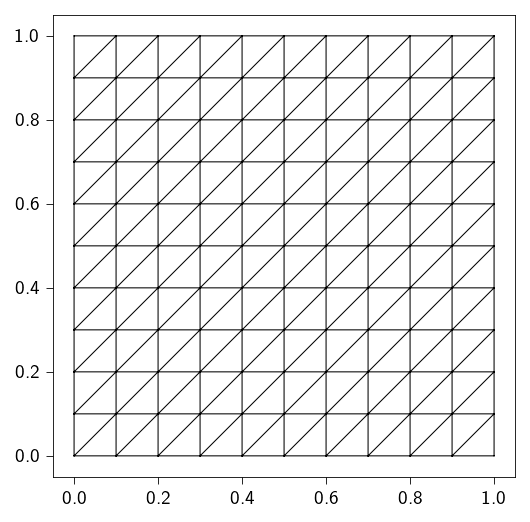

In [2]:
mesh = Mesh.unit_square(10, 10)

plt.style.use(STYLE_PATH)
plt.figure(figsize=(4, 4))
plt.triplot(*mesh.coords.T, mesh.elements, color="k", lw=0.5)
plt.gca().set_aspect("equal")

In [3]:
from femsolver.compound import Compound, field

n_nodes = mesh.coords.shape[0]


class Solution(Compound):
    u = field(shape=(n_nodes, 2))
    phi = field(shape=(n_nodes,))


sol = Solution()
sol.unpack(sol.pack())

### Thermo-mechanical coupling

For a domain $\Omega$ with thermal conductivity $k$ and an internal source $Q$ (heat per unit volume per unit time), the equation is:

$$
\nabla \cdot (k \nabla T) + Q = 0 \quad \text{in } \Omega
$$

The thermal functional to be minimized is:

$$
\Pi_\text{d}(c) = \int_{\Omega} \left( \frac{1}{2} D (\nabla c \cdot \nabla c) - Q c \right) dV - \int_{\Gamma_q} \bar{q} c \, dA
$$


## Defining the constitutive model

$$
\psi_\text{d} = \frac{1}{2} D (\nabla c \cdot \nabla c) - Q.c
$$


In [4]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Diffusion coefficient
    lmbda: float  # Diffusion coefficient
    D: float  # Diffusion coefficient


mat = Material(mu=1.0, lmbda=1.0, D=1.0)

In [5]:
tri = element.Tri3()
op = Operator(mesh, tri)

line = element.Line2()
op_line = Operator(mesh, line)

In [6]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.T)


@auto_vmap(eps=2, c_quad=0, mu=0, lmbda=0)
def compute_stress(eps: Array, c_quad: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    kappa = 1.0
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I - kappa * c_quad * I


@auto_vmap(grad_u=2, c=0, mat=0)
def strain_energy(grad_u: Array, c: Array, mat: Material) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, c, mat.mu, mat.lmbda)
    return 0.5 * jnp.sum(eps * sig)


@auto_vmap(grad_c=1, D=0)
def diffusion_potential(grad_c: Array, D: float) -> Array:
    return 0.5 * D * (grad_c @ grad_c)


@jax.jit
def total_energy(u_flat):
    u, phi = sol.unpack(u_flat)
    strain_energy_density = strain_energy(op.grad(u), op.eval(phi), mat)
    diffusion_energy_density = diffusion_potential(op.grad(phi), mat.D)

    return op.integrate(strain_energy_density) + op.integrate(diffusion_energy_density)

In [7]:
gradient = jax.jacrev(total_energy)
hessian = jax.jacfwd(gradient)

In [10]:
K_coupled = hessian(sol.pack())

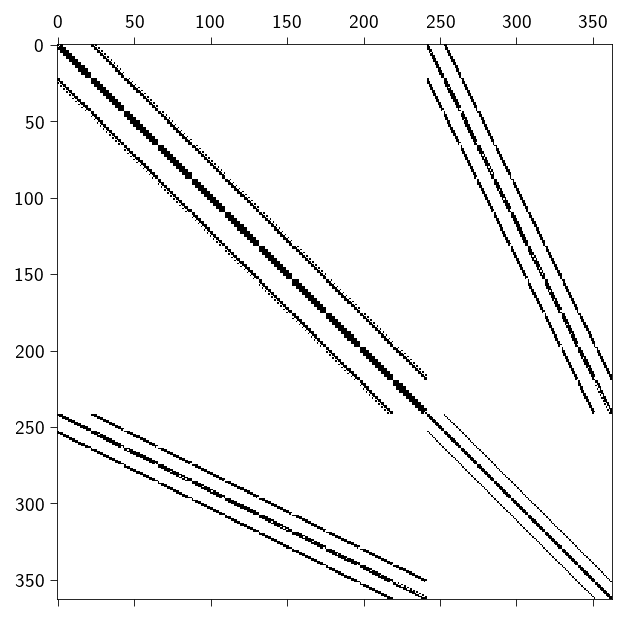

In [11]:
plt.spy(K_coupled)
plt.show()

In [13]:
n_total_dofs = u_flat.shape[0]
sparsity_pattern = femsolver.sparse.create_sparsity_pattern(
    mesh.elements, n_dofs_per_node=2, K_shape=(n_total_dofs, n_total_dofs)
)

plt.spy(sparsity_pattern.todense())
plt.show()

AttributeError: module 'femsolver' has no attribute 'sparse'

In [27]:
import sparsejac

In [28]:
hessian_sparse = sparsejac.jacfwd(gradient, sparsity=sparsity_pattern)

In [29]:
Kd_sparse = hessian_sparse(c)

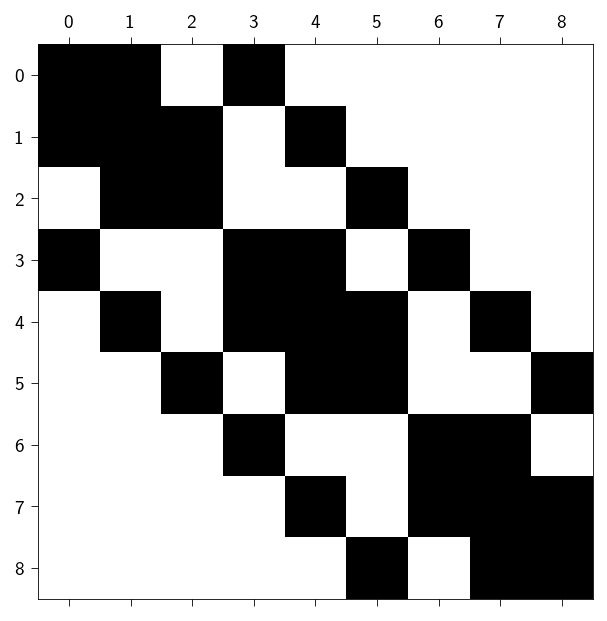

In [30]:
plt.spy(Kd_sparse.todense())
plt.show()